In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale, resize, radon, iradon
from skimage.filters import gaussian
import scipy
from scipy.signal import argrelextrema
from scipy.interpolate import CubicSpline
from scipy.optimize import root, leastsq
from PIL import Image
import sys


In [2]:
def plot(plots, figsize=(10,10)):
    plt.figure(figsize=figsize)
    z = zip(plots)
    a = len(plots)
    b = list(range(a))
    for i in range(a):
        n = next(z)
        plt.subplot(int((a/2)*100+21+b[i]))
        #snr = entropy(n[0],rectangle(n[0].shape[0],n[0].shape[1])) #np.mean(n[0])/np.std(n[0])
        #plt.title('SNR = ' + str(snr)[0:5])
        plt.imshow(n[0])
    plt.show()

def threshold_plot(plot, amount):
    plot = plot - (np.mean(plot)-np.std(plot)/amount)
    plot = np.asarray([0 if i <0 else i for i in plot])
    return plot

def add_noise(array, mean, std, multiplier):
    noise = np.random.normal(mean,std ,array.shape)*multiplier
    array = array+noise-np.min(noise)
    array = np.array(((array-np.min(array))/np.max(array))*(2**16), dtype=np.uint16)
    return array


In [3]:
imshape = 512
im = (imshape,imshape)
offset = 0#int(imshape/10)+300
posa = int(imshape/2)-int(512/2)+offset
posb = int(imshape/2)+int(512/2)+offset

noise = 50
#Load Shepp Logan Phantom
slp = np.asarray(plt.imread('./pictures/Shepp-Logan_Phantom.tif')[:,:], dtype= float)

#Create space for offsetting phantom
phantom=np.zeros(im)
'''
if posa > phantom.shape[0] or posb>phantom.shape[1]:
    phantom = slp[len(slp)-offset:len(slp)+offset,len(slp)-offset:len(slp)+offset]
else:
    phantom[posa:posb,posa:posb] = slp
'''
phantom = slp[int(512/2)-int(imshape/2):int(512/2)+int(imshape/2),int(512/2)-int(imshape/2):int(512/2)+int(imshape/2)]
number_angles = 1000

(482, 500)
65536.0 65157 2.06207285164173 4.401024334125069


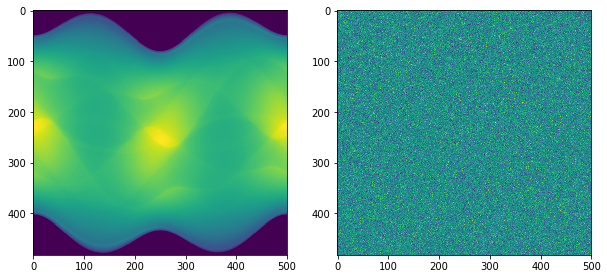

In [4]:
'''
Circle = False
theta = np.linspace(0., 360, number_angles, endpoint=False)

sinogram = radon(phantom, theta=theta, circle=Circle)
np.save('sinogram2', sinogram)
'''
sinogram = np.load('sinogram_off_center.npy')
sinogram = sinogram*2**16/np.max(sinogram)
sinogram_noise = add_noise(sinogram,np.mean(sinogram),np.std(sinogram), noise)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(sinogram)
plt.subplot(122)
plt.imshow(sinogram_noise)
plt.show
# In[145]:
print(sinogram.shape)
snr = lambda x: np.mean(x)/np.std(x)
print(np.max(sinogram), np.max(sinogram_noise), snr(sinogram), snr(sinogram_noise))

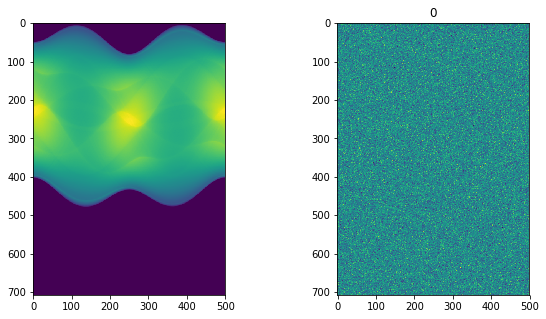

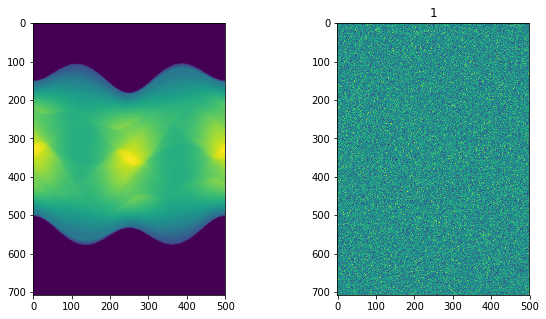

In [5]:
reals_odd = []
reals_even= []
j = iter(list(range(50)))
shifting_range = sinogram.shape[0]-300
for i in range(shifting_range):
    #shift sinogram so rotation center is off of image center and add noise
    sinogram_shift_noiseless = np.zeros((int(sinogram.shape[0]*2-256),sinogram.shape[1]))
    sinogram_shift_noiseless[i:i+sinogram.shape[0],:] = sinogram

    sinogram_shift = add_noise(sinogram_shift_noiseless,np.mean(sinogram),np.std(sinogram), noise)
    if i %100==0:
        a = next(j)
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.imshow(sinogram_shift_noiseless)
        plt.subplot(122)
        plt.imshow(sinogram_shift)
        plt.title(str(a))
        plt.show()
    #Mess around with increasing dynamic range
    #sinogram_resized = resize(sinogram_shift, (int(sinogram_shift.shape[0] / 2), int(sinogram_shift.shape[1] / 1)), clip=False)

    resize_factor = 2
    sinogram_resized = np.zeros((int(sinogram_shift.shape[0]/resize_factor),int(sinogram_shift.shape[1])))
    for i in range(sinogram_resized.shape[0]):
        sinogram_resized[i,:] = sinogram_shift[i*resize_factor,:]+sinogram_shift[i*resize_factor+1,:]
        

    #plot((sinogram_shift, sinogram_resized))
    snr = np.mean(sinogram_shift)/np.std(sinogram_shift)


    # # Find Center of Mass with strict thresholding

    # In[147]:


    #sum projections from sinogram to find rotation center (sym center)
    #print(snr)
    threshold_amount = snr #increase threshold to remove off-feature noise
    fft_cutoff = 5 #decrease fft cutoff to reduce high frequencies

    rowsum = threshold_plot(np.sum(sinogram_shift, axis=1),threshold_amount)
    #var = threshold_plot(np.std(sinogram_shift, axis=1),threshold_amount)
    #mean = threshold_plot(np.mean(sinogram_shift, axis=1),threshold_amount)


    #sum for interpolated image
    rowsum2 = threshold_plot(np.sum(sinogram_resized, axis=1),threshold_amount)
    #var2 = threshold_plot(np.std(sinogram_resized, axis=1),threshold_amount)
    #mean2 = threshold_plot(np.mean(sinogram_resized, axis=1),threshold_amount)

    #fft for row sum
    fft = np.fft.fft(np.sum(sinogram_shift, axis=1))
    #plt.plot(fft[0:10])
    plt.show()
    fft[fft_cutoff:]=0+0j
    ifft = threshold_plot(np.fft.ifft(fft),threshold_amount)

    fft2 = np.fft.fft(np.sum(sinogram_resized, axis=1))
    fft2[fft_cutoff:]=0
    ifft2 = threshold_plot(np.fft.ifft(fft2),threshold_amount)
    '''
    #fft for variance
    fftv = np.fft.fft(np.std(sinogram_shift, axis=1))
    fftv[fft_cutoff:]=0
    ifftv = threshold_plot(np.fft.ifft(fftv),threshold_amount)

    fftv2 = np.fft.fft(np.std(sinogram_resized, axis=1))
    fftv2[fft_cutoff:]=0
    ifftv2 = threshold_plot(np.fft.ifft(fftv2),threshold_amount)
    '''
    #Center of Mass (COM) guess at root
    COM = scipy.ndimage.measurements.center_of_mass(np.real(ifft))[0]/len(ifft)*sinogram_shift.shape[0]
    COM2 = scipy.ndimage.measurements.center_of_mass(np.real(ifft2))[0]/len(ifft2)*sinogram_resized.shape[0]


    r = np.arange(0,sinogram_shift.shape[0],resize_factor)#sinogram_resized.shape[0])

    
    '''
    plt.figure(figsize=(15,10))
    plt.suptitle('True Center: ' + str(true_center))
    plt.subplot(222)
    plt.title('ifft rowsum, center: ' + str(COM)[0:5]+' ifft2 rowsum, center: '+str(COM2*resize_factor)[0:5])
    plt.plot(ifft)
    plt.plot(r,np.real(ifft2))

    plt.subplot(221)
    plt.title('SNR ='+ str(np.std(rowsum)/np.mean(rowsum)) + '\nSNR2 = '+ str(np.std(rowsum2)/np.mean(rowsum2)))
    plt.plot(rowsum)
    plt.plot(r,rowsum2)

    plt.subplot(223)
    plt.title('SNR ='+ str(np.std(mean)/np.mean(mean)) + ' SNR2 = '+ str(np.std(mean)/np.mean(mean)))
    plt.plot(var)
    plt.plot(r, var2)

    plt.subplot(224)
    plt.title('ifft var')
    plt.plot(np.real(ifftv))
    plt.plot(r, np.real(ifftv2))

    plt.show()

    '''
    # # All COM
    # 

    # In[148]:


    #Calculate Center of Mass

    #threshold the plots
    '''
    rowsum = threshold_plot(np.sum(sinogram_shift, axis=1))
    var = threshold_plot(np.std(sinogram_shift, axis=1))
    mean = threshold_plot(np.mean(sinogram_shift, axis=1))

    rowsum2 = threshold_plot(np.sum(sinogram_resized, axis=1))
    var2 = threshold_plot(np.std(sinogram_resized, axis=1))
    mean2 = threshold_plot(np.mean(sinogram_resized, axis=1))
    '''
    #print('True Center ', true_center)
    #print('var ', scipy.ndimage.measurements.center_of_mass(var)[0]/len(var)*sinogram_shift.shape[0])
    #print('var2 ', scipy.ndimage.measurements.center_of_mass(var2)[0]/len(var2)*sinogram_shift.shape[0])
    #print('rowsum ', scipy.ndimage.measurements.center_of_mass(rowsum)[0]/len(rowsum)*sinogram_shift.shape[0])
    #print('rowsum2 ', scipy.ndimage.measurements.center_of_mass(rowsum2)[0]/len(rowsum2)*sinogram_shift.shape[0])
    #print('ifft ', scipy.ndimage.measurements.center_of_mass(np.real(ifft))[0]/len(ifft)*sinogram_shift.shape[0])
    #print('ifft2 ', scipy.ndimage.measurements.center_of_mass(np.real(ifft2))[0]/len(ifft2)*sinogram_shift.shape[0])


    # # Max value 
    # Works well when sample is sufficiently on-center but detector is off-center.
    # 
    # Works poorly when sample is far off-center.

    # In[149]:




    # # Interpolate function to find Root with COM as initial guess

    # In[150]:


    #Rethreshold to lower level and include more data
    threshold_amount = None#increase threshold to remove off-feature noise
    fft_cutoff = 50 #decrease fft cutoff to reduce high frequencies
    fft_threshold = None
    r0_even = []
    r0_odd = []

    #Use COM to guess root
    rowsum_grad = np.sum(sinogram_shift, axis=1)

    #fft for row sum
    fft = np.fft.fft(rowsum_grad) #np.sum(sinogram_shift, axis=1))
    fft_even = np.ones(fft.shape)*0+0j
    fft_odd = np.ones(fft.shape)*0+0j
    for i in range(1):
        fft_even[i*2]=fft[i*2]
        fft_odd[i*2+1]=fft[i*2+1]
        
    #fft_even[200:]=0+0j
    #fft_odd[200:]=0+0j

    #Interpolate function and guess root
    ifft_even = np.fft.ifft(fft_even)#threshold_plot(np.fft.ifftshift((np.fft.ifft(fft))),fft_threshold)
    ifft_odd = np.fft.ifft(fft_odd)
    #ifft_odd = threshold_plot((np.fft.ifft(fft_odd)),fft_threshold)
    x = np.arange(0,len(np.gradient(np.real(ifft_even)))*2,2)
    f2_even = CubicSpline(x, np.gradient(np.real(ifft_even)))
    f2_odd = CubicSpline(x, np.gradient(np.real(ifft_odd)))
    r0_even = root(f2_even,COM)['x'][0]
    r0_odd = root(f2_odd,COM)['x'][0]
    reals_even.append(np.sum(np.real(fft_even)))
    reals_odd.append(np.sum(np.real(fft_odd)))
plt.show()

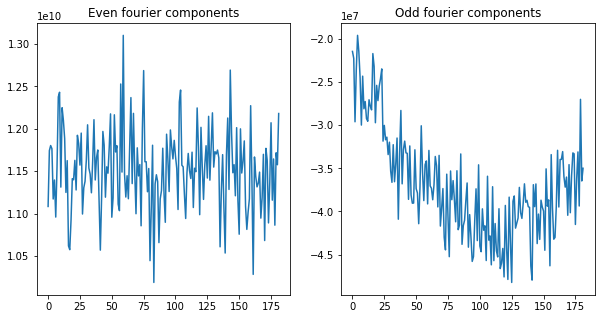

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('Even fourier components')
plt.plot(reals_even)
plt.subplot(122)
plt.title('Odd fourier components')
plt.plot(reals_odd)
plt.show()

# Fit odd component to sine curve

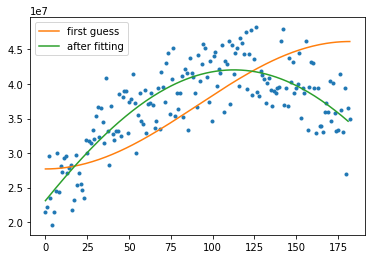

In [7]:


N = len(reals_odd) # number of data points
t = np.linspace(0, N, N)
#f = None # Optional!! Advised not to use
data = -1*np.asarray(reals_odd) # create artificial data with noise

guess_mean = np.mean(data)
guess_std = 3*np.std(data)/(2**0.5)/(2**0.5)
guess_phase = -np.pi/2
guess_freq = np.pi/(N)
guess_amp = np.max(data)
guess_decay = 1

# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = guess_std*np.sin(guess_freq*t+guess_phase) + guess_mean

# Define the function to optimize, in this case, we want to minimize the difference
# between the actual data and our "guessed" parameters
optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data
est_amp, est_freq, est_phase, est_mean= leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

# recreate the fitted curve using the optimized parameters
#data_fit = est_amp*est_decay*np.sin(est_freq*t+est_phase) + est_mean

# recreate the fitted curve using the optimized parameters

fine_t = np.arange(0,N,1)
data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean

plt.plot(t, data, '.')
plt.plot(t, data_first_guess, label='first guess')
plt.plot(fine_t, data_fit, label='after fitting')
plt.legend()
plt.show()

In [8]:
x_range = np.linspace(0,N, 1)
fit = est_amp*np.sin(est_freq*x_range+est_phase)+est_mean


fft_odd_max = argrelextrema(abs(data_fit), np.greater)[0]

print(sinogram_shift.shape[0]/2)
print(fft_odd_max)#*sinogram_shift.shape[0]/shifting_range)
print(argrelextrema(abs(data_fit), np.less)[0])#*sinogram_shift.shape[0]/shifting_range)

354.0
[113]
[]


In [9]:
sinogram.shape[0]/2+fft_odd_max

array([354.])